In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [39]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [40]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_v9.1_test/'

In [41]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_test/


In [42]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [43]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [44]:
dir_image = dir_project + info_basic['dir_image'] + 'post_K-S_analysis/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)

In [45]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [46]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']
key_subworks = info_basic['key_subworks']

In [47]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [48]:
dir_partition = dir_project + info_basic['dir_partition']
dir_partition_probes = dir_project_probes + info_basic_probes['dir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['dir_partition']

In [49]:
stations_probes = {}
lat_probes = {}
lon_probes = {}
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_stations_this.astype(float)
    lon_probes[probe] = lon_stations_this.astype(float)

stations_targets = {}
lat_targets = {}
lon_targets = {}
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_stations_this.astype(float)
    lon_targets[target] = lon_stations_this.astype(float)

stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [50]:
probe_accept_all = info_basic_bi['probe_accept']

In [51]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [52]:
# read disp data
disp_all = {}
ff_all = {}
ds_probe_all = {}
for probe in probes:
    file_disp = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
    disp_all[probe] = np.loadtxt(file_disp,delimiter=',')[:,1]
    ff_all[probe] = np.loadtxt(file_disp,delimiter=',')[:,0]
    file_ds = dir_project_probes  + info_basic_probes['dir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

### Analysis

In [96]:
def new_target_comparison(key_subwork):
    global c_lim
    target = key_subwork[key_subwork.find('--')+2:]
    probes = info_basic_bi['probe'][key_subwork]
    probes_accept = probe_accept_all[target]

    # all stations
    lat_stations_this = lat[key_subwork]
    lon_stations_this = lon[key_subwork]

    # probe stations
    lat_stations_target = lat_targets[target]
    lon_stations_target = lon_targets[target]


    fig = plt.figure(figsize=(14,10))
    # partition comparison
    ax = plt.subplot(221)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    ax.scatter(np.mean(lon_stations_this), np.mean(lat_stations_this),marker='o',color='b',s=50,label='New center')
    ax.scatter(lon_stations_this, lat_stations_this,marker='o',color='g',s=20,label='New partition')
    ax.scatter(np.mean(lon_stations_target), np.mean(lat_stations_target),marker='^',color='b',s=50,label='Target center')
    ax.scatter(lon_stations_target, lat_stations_target,marker='^',color='r',s=5,label= 'Target partition')
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--', lw=1)
    ax.axis('off')
    ax.legend()
    # probe accepted comparison
    ax = plt.subplot(222)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    ax.scatter(lon_stations_this, lat_stations_this,marker='o',color='g',s=5,label='New partition')
    ax.axis('off')
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--', lw=1)
    #ax.scatter(lon_targets, lat_targets,marker='^',color='b',s=5,label= 'Target partition')

    flag_label_probe =  1
    flag_label_probe_accept =  1
    for probe in probes:
        if probe in probes_accept:
            if flag_label_probe_accept:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='r',s=30,label='Accepted Porbe center')
                flag_label_probe_accept = 0
            else:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='r',s=30)
        else:
            if flag_label_probe:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='b',s=5,label='Porbe center')
                flag_label_probe = 0
            else:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='b',s=5)
    ax.legend()
    # all disp comparison
    ax = plt.subplot(223)
    for probe in probes:
        ax.scatter(ff_all[probe], disp_all[probe],label=probe,s=1)
    ax.set_ylim(c_lim)
    # accepted disp comparison
    ax = plt.subplot(224)
    flag_label_probe =  1
    flag_label_probe_accept =  1
    for probe in probes:
        if probe in probes_accept:
            if flag_label_probe_accept:
                ax.scatter(ff_all[probe], disp_all[probe],label='accepted',s=1)
                flag_label_probe_accept = 0
            else:
                ax.scatter(ff_all[probe], disp_all[probe],s=1)
        """
        else:
            if flag_label_probe:
                ax.scatter(f_sample, disp_all[probe],label="unaccepted",s=0.5,color='b')
                flag_label_probe = 0
            else:
                ax.scatter(f_sample, disp_all[probe],s=0.5,color='b')
        """
    ax.set_ylim(c_lim)
    ax.legend()
    plt.savefig(dir_image+'new_target_comparison_'+key_subwork+'.png',dpi=100)

In [97]:
def plot_disp_all(key_subwork):
    global key_subworks
    global c_lim
    global dir_image
    global info_basic_bi
    global info_basic_bi_probes
    global info_basic_bi_targets
    global info_basic_probes
    global f_lim
    global probes_accept
    
    f = info_basic_bi_probes['f']
    c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])
    num = len(probes)
    n_cols = int(np.ceil(np.sqrt(num)))+1
    n_rows = int(np.floor(np.sqrt(num)))
    fig = plt.figure(figsize=(n_cols*3,n_rows*2))
    for i in range(num):
        ax = plt.subplot(n_rows,n_cols,i+1)
        ax = plotlib.plot_fj(ax,ds_probe_all[probes[i]],probes[i],f,c,0,c_map='jet')
        ax.scatter(ff_all[probes[i]], disp_all[probes[i]],label=probes[i],s=1)
        ax.set_ylim(c_lim)
        ax.set_xlim(f_lim)
        ax.legend()
        if probes[i] in probes_accept:
            ax.set_title(probes[i]+' (accepted)',color='r')
        else:
            ax.set_title(probes[i],color='b')
    plt.tight_layout()
    plt.savefig(dir_image+'disp_all_'+key_subwork+'.png',dpi=60)

In [98]:
nums_repick = [458]
key_subworks = []
for num in nums_repick:
    tag = str(num)
    for key_subwork in info_basic['key_subworks']:
        if tag == key_subwork.split('--')[0]:
            key_subworks.append(key_subwork)
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

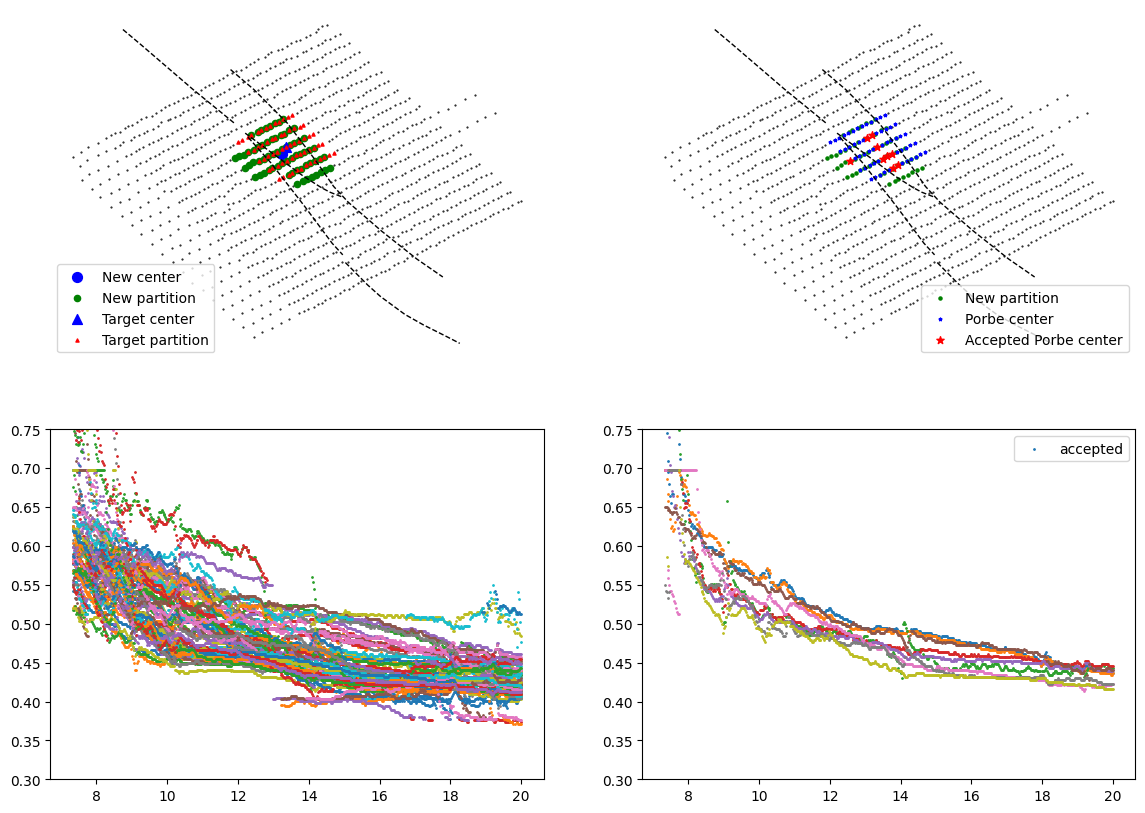

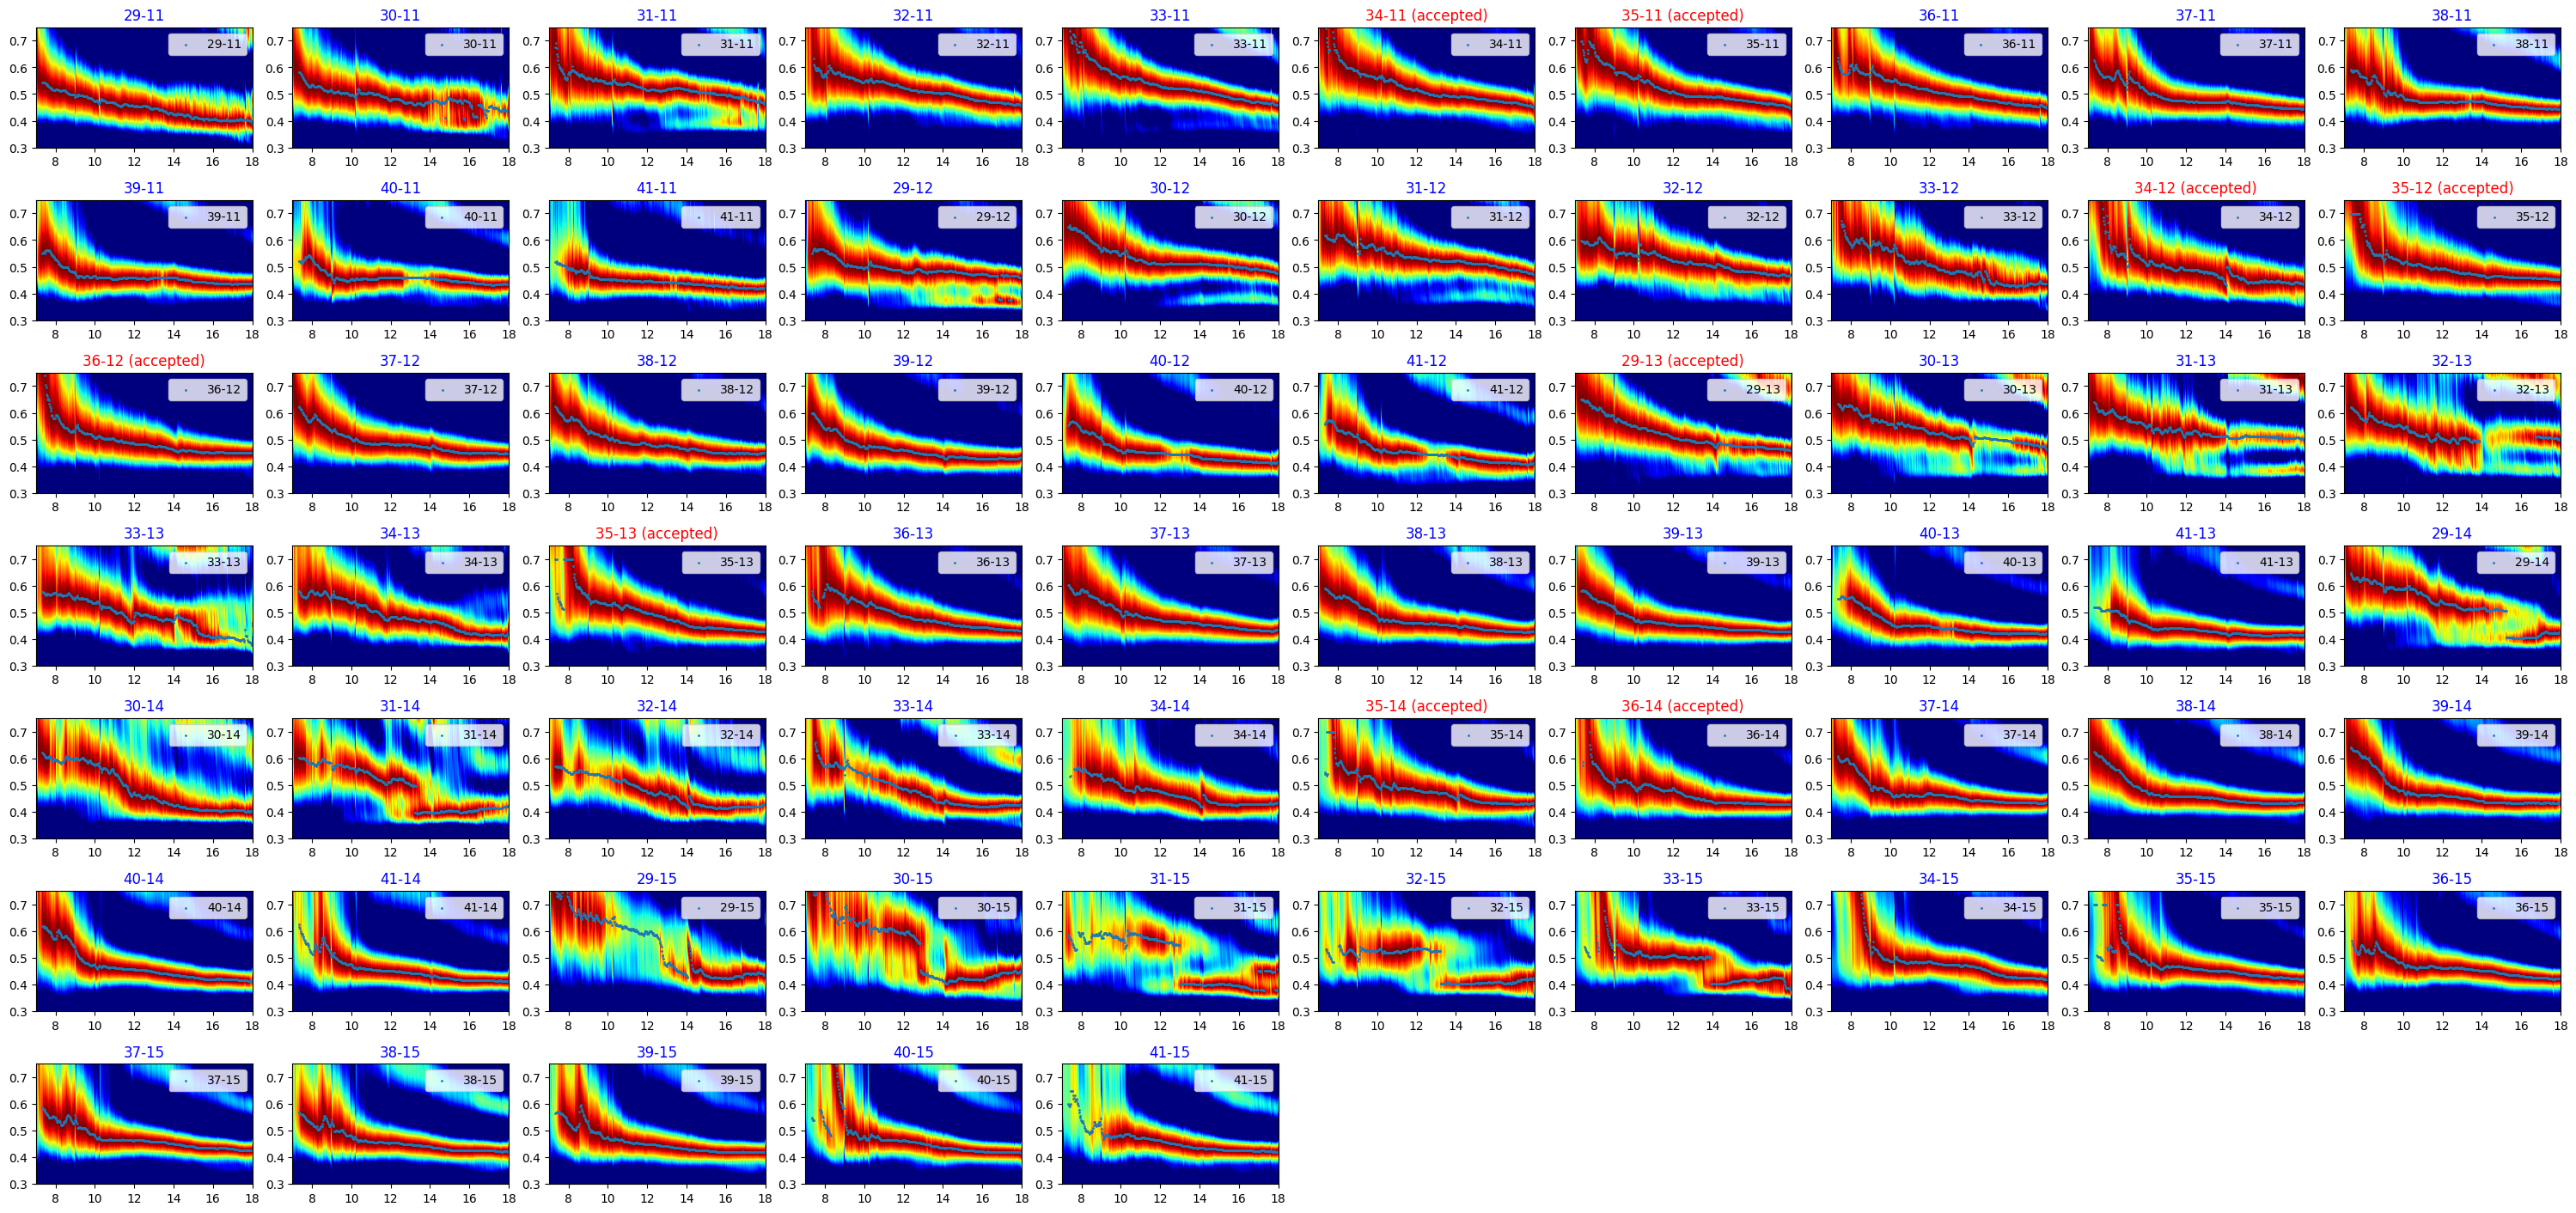

In [99]:
c_lim = [0.3,0.75]
f_lim = [7,18]
for key_subwork in key_subworks:
    target = key_subwork[key_subwork.find('--')+2:]
    probes = info_basic_bi['probe'][key_subwork]
    probes_accept = probe_accept_all[target]
    new_target_comparison(key_subwork)
    plot_disp_all(key_subwork)